<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/PyTorch/Nithin/DLS_Assignment_3_nvaradha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning Systems Fall 2022 Assignment 3

### Nithin Varadharajan (nvaradha)

### Problem 1: Data Augmentation

1. CIFAR10 is a pretty straightforward image classification task, that consists of 10 visual object
classes.
2. Download them from here and be ready to use it. Both PyTorch and Tensorflow have options
to conveniently load them, but I chose to download them directly and mess around because
I found it easier.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_1", 'rb')
dict_1 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_2", 'rb')
dict_2 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_3", 'rb')
dict_3 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_5", 'rb')
dict_4 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_5", 'rb')
dict_5 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/test_batch", 'rb')
dict_test = cPickle.load(f,encoding='latin1')
f.close()


In [ ]:
import copy

train_data = np.concatenate((dict_1['data'], dict_2['data'], dict_3['data'], dict_4['data'], dict_5['data']), axis=0)

print(train_data.shape)

joinedlist = dict_1['labels'] + dict_2['labels'] + dict_3['labels'] + dict_4['labels'] + dict_5['labels']

train_labels = np.asarray(joinedlist)

print(train_labels.shape)

(50000, 3072)
(50000,)


3. Set aside 5,000 training examples for validation. \\
4. **Build your baseline CNN classifier**. \\
(a) The images need to be reshaped into 32 × 32 × 3 tensors. \\
(b) Each pixel is an integer with 8bit encoding (from 0 to 255). Transform them down to a
floating point with a range [0, 1]. 0 means a black pixel and 1 is a white one. \\
(c) People like to rescale the pixels to [-1, 1] so that the input to the CNN is well centered
around 0, instead of 0.5.

In [ ]:
train_data = train_data.reshape(50000, 3, 32, 32).astype("uint8")

In [ ]:
print(train_data.shape)

(50000, 3, 32, 32)


In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, shuffle = True)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(45000, 3, 32, 32)
(5000, 3, 32, 32)
(45000,)
(5000,)


In [ ]:
# Scale Data into [-1,1] range from [0,255]

X_train = X_train.astype(float)
X_train = (((X_train / 255) * 2) - 1)

X_val = X_val.astype(float)
X_val = (((X_val / 255) * 2) - 1)

In [ ]:
# Convert to torch tensors

X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)


In [ ]:
# Set Hyperparameters
n_epochs = 200 # max_epochs
batch_size_val = 100
batch_size_train = 100
batch_size_test = 100
learning_rate = 0.001 # learn rate
log_interval = 1 # log every _ epoch

patience = 20  # epochs after which training should stop if no improvement

In [ ]:
# Get Datasets
from torch.utils.data import TensorDataset, DataLoader

Train_dataset = TensorDataset(X_train, y_train)
Val_dataset = TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(Train_dataset,batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(Val_dataset,batch_size=batch_size_val, shuffle=False)

(d) I know you are eager to try out a fancier net architecture, but let’s stick to this simple
one: \\
**1st 2d conv layer:** there are 10 kernels whose size is 5x5x3; stride=1 \\
**Maxpooling:** 2x2 with stride=2 \\
**1st 2d conv layer:** there are 10 kernels whose size is 5x5x10; stride=1 \\
**Maxpooling:** 2x2 with stride=2 \\
**1st fully-connected layer:** [flattened final feature map] x 20 \\
**2st fully-connected layer:** 20 x 10 Softmax on the 10 classes \\
Let’s stick to ReLU for activation and the Kaiming He’s initializer. \\
(e) Train this net with an Adam optimizer with a default initial learning late (i.e. 0.001). \\
Check on the validation accuracy at the end of every epoch. Report your validation 
accuracy over the epochs as a graph. This is the performance of your baseline system

In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN2D_base_network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv2d = nn.Conv2d(in_channels = 3,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',    
                                stride = (1,1) # stride of conv
          
        ) 
        self.conv2d_2 = nn.Conv2d(in_channels = 10,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',
                                stride = (1,1) # stride of 
                       
        ) 
        self.maxpool2d = nn.MaxPool2d(kernel_size = (2,2),stride=2)
        
        self.fc1 = nn.Linear(640, 20)
        self.fc2 = nn.Linear(20, 10)
        

        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        #self.LeakyReLU = nn.LeakyReLU()
        #self.Dropout_1 = nn.Dropout(p=.2)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations


        x = self.conv2d(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
 
        x = self.conv2d_2(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.ReLU(x)

        x = self.fc2(x)
        x = self.ReLU(x)

        return x

In [ ]:
import math
def weight_init(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
    torch.nn.init.zeros_(m.bias) # fill bias with zeros
  elif isinstance(m, nn.Conv2d):
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
    torch.nn.init.zeros_(m.bias) # fill bias with zeros

# Send model to GPU
CNN2D_base_network = CNN2D_base_network().to(device)
CNN2D_base_network.apply(weight_init)
CNN2D_base_network = CNN2D_base_network.float()
print(CNN2D_base_network)

CNN2D_base_network(
  (conv2d): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2d_2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (ReLU): ReLU()
)


In [ ]:
# Define optimizer and loss

optimizer = torch.optim.Adam(CNN2D_base_network.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_accuracy = 0 # captures best accuracy
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None
validation_acc_list = []

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list)

In [ ]:
from sklearn.metrics import accuracy_score

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch
 
  
  print("Training model")

  while ( (epoch <= n_epochs) ):
    
    # Training
    CNN2D_base_network.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data = data.to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = CNN2D_base_network(data.float())
      loss = loss_func(batch_outputs, batch_labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch

    # Evaluation 
    CNN2D_base_network.eval()
    data_list = []
    lbl_list = []
    pred_list = []
    with torch.no_grad():
      for data, target in val_loader:
        
        data = data.to(device)
        test_batch_labels = target.numpy()
        test_batch_pred = F.softmax(CNN2D_base_network.forward(data.float()), dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()

        data_list.append(data.cpu().numpy())
        lbl_list.append(test_batch_labels)
        pred_list.append(test_batch_pred)
        
    data_array = np.concatenate(data_list, axis=0)
    lbl_array = np.concatenate(lbl_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)

    epoch_acc = accuracy_score(lbl_array,pred_array)

    validation_acc_list.append(epoch_acc)
    
    # Early Stop
    # if acc better than previous
    if(epoch_acc > bst_accuracy):

      # Save result
      bst_accuracy = epoch_acc

      # Save test data
      bst_test_data = data_array
      bst_test_labels = lbl_array
      bst_prediction_array = pred_array
      
      # Save Model
      bst_model = CNN2D_base_network
      bst_model_state_dict = CNN2D_base_network.state_dict()
      bst_opt_state_dict = optimizer.state_dict()
      # torch.save(model, 'best_mnist_model.pt')
    
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Total Training Loss: {}, Epoch Accuracy: {}, Best Accuracy: {} \n ".format(epoch, train_loss, epoch_acc, bst_accuracy))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list)
  return Training_Return

In [ ]:
# Train 
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list = res

# Best Model
print("Best Accuracy Model was : {:.2f}".format(bst_accuracy))

Training model
Epoch: 1, Total Training Loss: 896.8500036001205, Epoch Accuracy: 0.3874, Best Accuracy: 0.3874 
 
Epoch: 2, Total Training Loss: 800.8827217817307, Epoch Accuracy: 0.4274, Best Accuracy: 0.4274 
 
Epoch: 3, Total Training Loss: 766.301615357399, Epoch Accuracy: 0.4506, Best Accuracy: 0.4506 
 
Epoch: 4, Total Training Loss: 742.4980583190918, Epoch Accuracy: 0.4528, Best Accuracy: 0.4528 
 
Epoch: 5, Total Training Loss: 724.6388646364212, Epoch Accuracy: 0.4696, Best Accuracy: 0.4696 
 
Epoch: 6, Total Training Loss: 712.3235485553741, Epoch Accuracy: 0.4716, Best Accuracy: 0.4716 
 
Epoch: 7, Total Training Loss: 701.4523041248322, Epoch Accuracy: 0.4742, Best Accuracy: 0.4742 
 
Epoch: 8, Total Training Loss: 692.2595953941345, Epoch Accuracy: 0.496, Best Accuracy: 0.496 
 
Epoch: 9, Total Training Loss: 685.0504778623581, Epoch Accuracy: 0.4866, Best Accuracy: 0.496 
 
Epoch: 10, Total Training Loss: 677.6197160482407, Epoch Accuracy: 0.4888, Best Accuracy: 0.496 
 

In [ ]:
import pickle

with open("/content/drive/My Drive/DLS_Assignments/3/Q1_P1_res", "wb") as fp:   
  pickle.dump(validation_acc_list, fp)

In [ ]:
with open("/content/drive/My Drive/DLS_Assignments/3/Q1_P1_res", "rb") as fp:   
  validation_acc_list = pickle.load(fp)

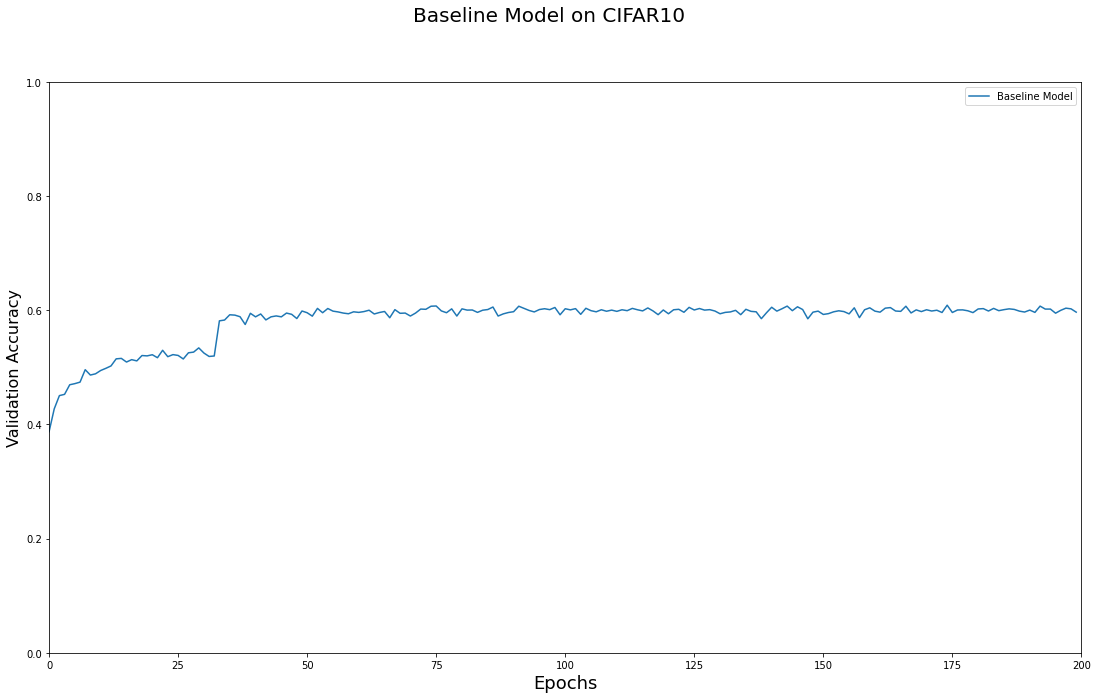

In [ ]:
# plot Baseline

x = np.arange(200)

plt.plot(x, validation_acc_list, label = 'Baseline Model')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('Baseline Model on CIFAR10', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=16)

ax = plt.gca()
ax.set_xlim([0, 200])
ax.set_ylim([0, 1.0])

plt.legend()
plt.show()

 **5.** Build another classifier using an augmented dataset. Prepare four different datasets out of the original CIFAR10 training set (except for the 5 000 you set aside for validation): \\
(a) I know you already changed the scale of the pixels from [0,255] to [-1,+1]. Let’s go back
to the intermediate range, [0,1]. \\
(b) Augmented dataset #1: Brighten every pixel in every image by 10%, e.g., by multiplying 1.1. Make sure though, that they don’t exceed 1. For example, you may want to
do something like this: np.minimum(1.1*X, 1). \\
(c) Augmented dataset #2: Darken every pixel in every image by 10%, e.g., by multiplying 0.9. \\
(d) Augmented dataset #3: Flip all images horizontally (not upside down, but in the
left-right direction). As if they are mirrored. \\
(e) Augmented dataset #4: The original training set. \\
(f) Merge the four augmented dataset into one gigantic training set. Since there are 45,000
images in the original training set (after excluding the validation set), after the augmentation you have 45,000×4=180,000 images. Each original image has four different
versions: brighter, darker, horizontally flipped, and original versions. Note that the four
share the same label: a darker frog is still a frog. \\
(g) Don’t forget to scale back to [-1,+1].


In [ ]:
# Convert to numpy
X_train = X_train.numpy()
X_val = X_val.numpy()
y_train = y_train.numpy()
y_val = y_val.numpy()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(45000, 3, 32, 32)
(45000,)
(5000, 3, 32, 32)
(5000,)


In [ ]:
# Scale Data from [-1,1] range into [0,1]
X_train = ((X_train + 1) * 0.5) 

In [ ]:
# Augmented dataset #1

X_train_1 = np.minimum(1.1*X_train, 1).reshape(45000, 3, 32, 32)

# Augmented dataset #2

X_train_2 = np.multiply(X_train, 0.9).reshape(45000, 3, 32, 32)

# Augmented dataset #3

X_train_3 = np.flip(copy.deepcopy(X_train.transpose(0,2,3,1)), axis = 2).transpose(np.argsort((0,2,3,1))).reshape(45000, 3, 32, 32)

# Original

X_train = X_train.reshape(45000, 3, 32, 32)

In [ ]:
Augmented_X_train = np.concatenate((X_train, X_train_1, X_train_2, X_train_3), axis = 0)
Augmented_y_train = np.concatenate((y_train,y_train,y_train,y_train), axis = 0)

In [ ]:
print(Augmented_X_train.shape)
print(Augmented_y_train.shape)

(180000, 3, 32, 32)
(180000,)


In [ ]:
# import gc

# del X_train
# del X_train_1
# del X_train_2
# del X_train_3
# gc.collect()

279

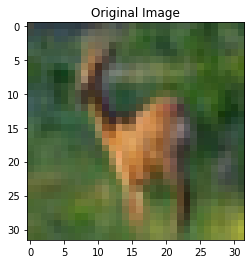

Label : 4


In [ ]:
# Original image

plt.imshow(Augmented_X_train[45].transpose(1,2,0).reshape(32,32,3), interpolation='nearest')
plt.title("Original Image")
plt.show()

print("Label : {}".format(Augmented_y_train[45]))

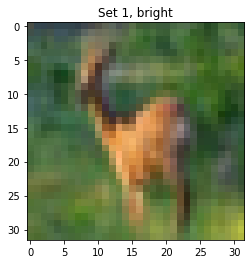

Label : 4


In [ ]:
# Set 1, bright

plt.imshow(Augmented_X_train[45045].transpose(1,2,0).reshape(32,32,3), interpolation='nearest')
plt.title("Set 1, bright")
plt.show()

print("Label : {}".format(Augmented_y_train[45045]))

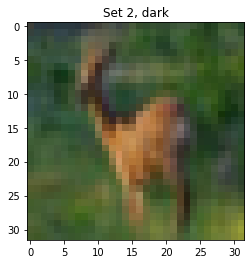

Label : 4


In [ ]:
# Set 2, dark

plt.imshow(Augmented_X_train[90045].transpose(1,2,0).reshape(32,32,3), interpolation='nearest')
plt.title("Set 2, dark")
plt.show()

print("Label : {}".format(Augmented_y_train[90045]))

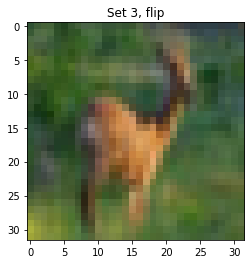

Label : 4


In [ ]:
# Set 3, flip

plt.imshow(Augmented_X_train[135045].transpose(1,2,0).reshape(32,32,3), interpolation='nearest')
plt.title("Set 3, flip")
plt.show()

print("Label : {}".format(Augmented_y_train[135045]))

In [ ]:
# Scale Data into [-1,1] range from [0,1]
Augmented_X_train = ((Augmented_X_train * 2) - 1) 

In [ ]:
# Convert to torch tensors
Augmented_X_train = torch.from_numpy(Augmented_X_train)
Augmented_y_train = torch.from_numpy(Augmented_y_train)

In [ ]:
# Set Hyperparameters
n_epochs = 200 # max_epochs
batch_size_val = 100
batch_size_train = 100
batch_size_test = 100
learning_rate = 0.001 # learn rate
log_interval = 1 # log every _ epoch

patience = 20  # epochs after which training should stop if no improvement

In [ ]:
# import gc

# del Train_dataset
# del train_loader
# gc.collect()

10005

In [ ]:
# Get Datasets
Train_dataset = TensorDataset(Augmented_X_train, Augmented_y_train)

train_loader = torch.utils.data.DataLoader(Train_dataset,batch_size=batch_size_train, shuffle=True)

(i) Train a fresh new network with the same architecture, but using this augmented dataset. \\
Record the validation accuracy over the epochs.


In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN2D_base_network_2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv2d = nn.Conv2d(in_channels = 3,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',    
                                stride = (1,1) # stride of conv
          
        ) 
        self.conv2d_2 = nn.Conv2d(in_channels = 10,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',
                                stride = (1,1) # stride of 
                       
        ) 
        self.maxpool2d = nn.MaxPool2d(kernel_size = (2,2),stride=2)
        
        self.fc1 = nn.Linear(640, 20)
        self.fc2 = nn.Linear(20, 10)
        

        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        #self.LeakyReLU = nn.LeakyReLU()
        #self.Dropout_1 = nn.Dropout(p=.2)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations


        x = self.conv2d(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
 
        x = self.conv2d_2(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.ReLU(x)

        x = self.fc2(x)
        x = self.ReLU(x)

        return x

In [ ]:
# Send model to GPU
CNN2D_base_network_2 = CNN2D_base_network_2().to(device)
CNN2D_base_network_2.apply(weight_init)
CNN2D_base_network_2 = CNN2D_base_network_2.float()
print(CNN2D_base_network_2)

CNN2D_base_network_2(
  (conv2d): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2d_2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (ReLU): ReLU()
)


In [ ]:
# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_accuracy = 0 # captures best accuracy
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None
validation_acc_list_2 = []

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2)

In [ ]:
# Define optimizer and loss

optimizer = torch.optim.Adam(CNN2D_base_network_2.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import accuracy_score

# Train Function
def train_2(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2 = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch
 
  
  print("Training model")

  while ( (epoch <= n_epochs) ):
    
    # Training
    CNN2D_base_network_2.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data = data.to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = CNN2D_base_network_2(data.float())
      loss = loss_func(batch_outputs, batch_labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch

    # Evaluation 
    CNN2D_base_network_2.eval()
    data_list = []
    lbl_list = []
    pred_list = []
    with torch.no_grad():
      for data, target in val_loader:
        
        data = data.to(device)
        test_batch_labels = target.numpy()
        test_batch_pred = F.softmax(CNN2D_base_network_2.forward(data.float()), dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()

        data_list.append(data.cpu().numpy())
        lbl_list.append(test_batch_labels)
        pred_list.append(test_batch_pred)
        
    data_array = np.concatenate(data_list, axis=0)
    lbl_array = np.concatenate(lbl_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)

    epoch_acc = accuracy_score(lbl_array,pred_array)

    validation_acc_list_2.append(epoch_acc)
    
    # Early Stop
    # if acc better than previous
    if(epoch_acc > bst_accuracy):

      # Save result
      bst_accuracy = epoch_acc

      # Save test data
      bst_test_data = data_array
      bst_test_labels = lbl_array
      bst_prediction_array = pred_array
      
      # Save Model
      bst_model = CNN2D_base_network_2
      bst_model_state_dict = CNN2D_base_network_2.state_dict()
      bst_opt_state_dict = optimizer.state_dict()
      # torch.save(model, 'best_mnist_model.pt')
    
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Total Training Loss: {}, Epoch Accuracy: {}, Best Accuracy: {} \n ".format(epoch, train_loss, epoch_acc, bst_accuracy))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2)
  return Training_Return

In [ ]:
# Train MNIST with test set as validation
res = train_2(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2 = res

# Best Model
print("Best Accuracy Model was : {:.2f}".format(bst_accuracy))

Training model
Epoch: 1, Total Training Loss: 2717.169799745083, Epoch Accuracy: 0.5452, Best Accuracy: 0.5452 
 
Epoch: 2, Total Training Loss: 2125.0485227108, Epoch Accuracy: 0.6048, Best Accuracy: 0.6048 
 
Epoch: 3, Total Training Loss: 1948.1513026952744, Epoch Accuracy: 0.6376, Best Accuracy: 0.6376 
 
Epoch: 4, Total Training Loss: 1845.2212132811546, Epoch Accuracy: 0.6586, Best Accuracy: 0.6586 
 
Epoch: 5, Total Training Loss: 1770.8595667481422, Epoch Accuracy: 0.6708, Best Accuracy: 0.6708 
 
Epoch: 6, Total Training Loss: 1695.5706270933151, Epoch Accuracy: 0.7008, Best Accuracy: 0.7008 
 
Epoch: 7, Total Training Loss: 1616.7058166265488, Epoch Accuracy: 0.7096, Best Accuracy: 0.7096 
 
Epoch: 8, Total Training Loss: 1563.0599008202553, Epoch Accuracy: 0.7118, Best Accuracy: 0.7118 
 
Epoch: 9, Total Training Loss: 1529.3939858078957, Epoch Accuracy: 0.7222, Best Accuracy: 0.7222 
 
Epoch: 10, Total Training Loss: 1499.7649193108082, Epoch Accuracy: 0.7248, Best Accuracy

In [ ]:
with open("/content/drive/My Drive/DLS_Assignments/3/Q1_P2_res", "wb") as fp:   
  pickle.dump(validation_acc_list_2, fp)

In [ ]:
with open("/content/drive/My Drive/DLS_Assignments/3/Q1_P2_res", "rb") as fp:   
  validation_acc_list_2 = pickle.load(fp)

6. Overlay the validation accuracy curve from the baseline with the new curve recorded from
the augmented dataset. I ran 200 epochs for both experiments and was able to see convincing
results (i.e., the data augmentation improves the validation performance).
7. In theory you have to conduct a test run on the test set, but let’s forget about it.

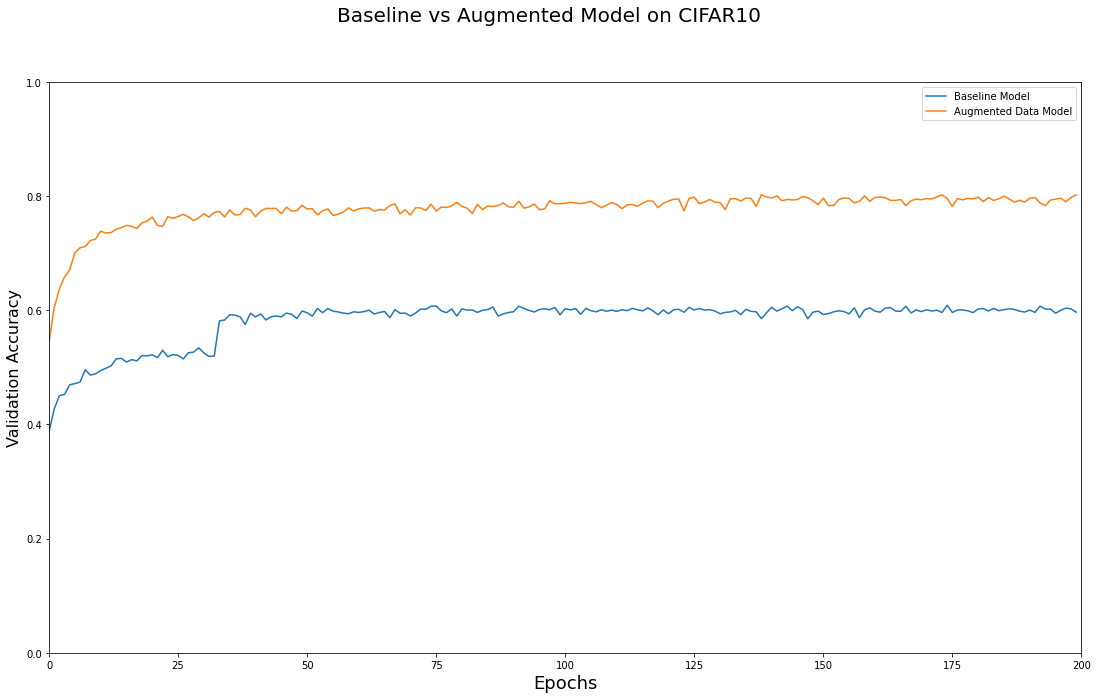

In [ ]:
# plot Baseline

x = np.arange(200)

plt.plot(x, validation_acc_list, label = 'Baseline Model')
plt.plot(x, validation_acc_list_2, label = 'Augmented Data Model')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('Baseline vs Augmented Model on CIFAR10', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=16)

ax = plt.gca()
ax.set_xlim([0, 200])
ax.set_ylim([0, 1.0])

plt.legend()
plt.show()

In our results for the model trained with the augmented data, we are seeing an almost 20% increase in accuracy on the validation set when the data augmentation is done, showing this medthods effectiveness for this CIFAR10 dataset.

### Problem 2: Self-Supervised Learning via Pretext Tasks

1. Suppose that you have only 50 labeled examples per class for your CIFAR10 classification
problem, totaling 500 training images. Presumably it might be tough to achieve a high
performance in this situation. Set aside those 500 examples from your training set (I chose
the last 500 examples).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_1", 'rb')
dict_1 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_2", 'rb')
dict_2 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_3", 'rb')
dict_3 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_5", 'rb')
dict_4 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/data_batch_5", 'rb')
dict_5 = cPickle.load(f,encoding='latin1')
f.close()

f = open("/content/drive/My Drive/DLS_Assignments/3/cifar-10-python/cifar-10-batches-py/test_batch", 'rb')
dict_test = cPickle.load(f,encoding='latin1')
f.close()


In [ ]:
import copy

train_data = np.concatenate((dict_1['data'], dict_2['data'], dict_3['data'], dict_4['data'], dict_5['data']), axis=0)

print(train_data.shape)

joinedlist = dict_1['labels'] + dict_2['labels'] + dict_3['labels'] + dict_4['labels'] + dict_5['labels']

train_labels = np.asarray(joinedlist)

print(train_labels.shape)

test_data = dict_test['data']

print(test_data.shape)

test_labels = np.asarray(dict_test['labels'])

print(test_labels.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [ ]:
train_data = train_data.reshape(50000, 3, 32, 32).astype("uint8")
test_data = test_data.reshape(10000, 3, 32, 32).astype("uint8")

In [ ]:
print(train_data.shape)
print(test_data.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [ ]:
# Scale Data into [0,1] range from [0,255]

train_data = train_data.astype(float)
train_data = (train_data / 255)

# Scale Test Data to [-1,1]
test_data = test_data.astype(float)
test_data = (((test_data / 255) * 2) - 1)

In [ ]:
from collections import Counter
Counter(train_labels[-500:])

Counter({3: 58, 8: 59, 9: 48, 1: 59, 4: 43, 0: 42, 5: 52, 6: 47, 7: 52, 2: 40})

Here I am choosing the last 500 examples to set aside, as there are about 50 examples per class and its fairly balanced

In [ ]:
big_data = copy.deepcopy(train_data[:49500])
big_data_labels = copy.deepcopy(train_labels[:49500])
small_data = copy.deepcopy(train_data[49500:])
small_data_labels = copy.deepcopy(train_labels[49500:])

In [ ]:
print(big_data.shape)
print(small_data.shape)

(49500, 3, 32, 32)
(500, 3, 32, 32)


In [ ]:
import gc 
del train_data
del train_labels
gc.collect()

22

2. **The pretext task:** \\
(a) We will try to improve this situation by learning from unlabeled dataset. \\
(b) We will assume that the rest of the 49,500 training examples are unlabeled. We will 
create a bogus classification problem using them. Let this unlabeled examples (or the
examples that you disregard their original labels) be “class 0”. \\
(c) “class 1”: Create a new class, by vertically flipping all the images upside down. \\
(d) “class 2”: Create another class, by rotating the images 90 degree counter-clock wise. \\
(e) Now you have three classes, each of which contains 49,500 examples that are with madeup labels. \\

In [ ]:
# Class 0
class_0_labels = np.zeros(49500).astype(float)

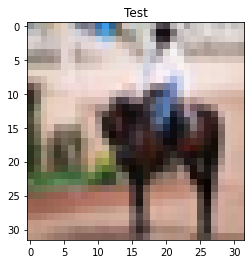

In [ ]:
# Test image
plt.imshow(big_data[11].transpose(1,2,0).reshape(32,32,3), interpolation='nearest')
plt.title("Test")
plt.show()

In [ ]:
# Class 1
big_data_1 = np.flip(copy.deepcopy(big_data.transpose(0,2,3,1)), axis = 1).transpose(np.argsort((0,2,3,1))).reshape(49500, 3, 32, 32)

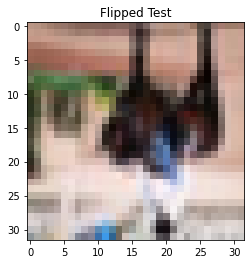

In [ ]:
# Vertically flipped test image
plt.imshow(big_data_1[11].transpose(1,2,0).reshape(32,32,3), interpolation='nearest')
plt.title("Flipped Test")
plt.show()

In [ ]:
class_1_labels = np.ones(49500).astype(float)

In [ ]:
# Class 2
big_data_2 = np.rot90(copy.deepcopy(big_data),axes=(-2,-1)).reshape(49500, 3, 32, 32)

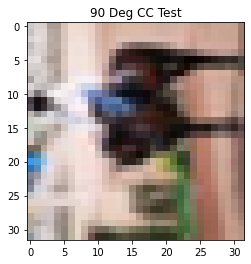

In [ ]:
# Rotated 90 degree CC test image
plt.imshow(big_data_2[11].transpose(1,2,0).reshape(32,32,3), interpolation='nearest')
plt.title("90 Deg CC Test")
plt.show()

In [ ]:
class_2_labels = np.full((49500,), 2.0).astype(float)

In [ ]:
Pretext_X_train = np.concatenate((big_data, big_data_1, big_data_2), axis = 0)
Pretext_y_train = np.concatenate((class_0_labels,class_1_labels,class_2_labels), axis = 0)

In [ ]:
import gc 
del big_data
del big_data_1
del big_data_2
del class_0_labels
del class_1_labels
del class_2_labels
gc.collect()

7461

In [ ]:
print(Pretext_X_train.shape)
print(Pretext_y_train.shape)

(148500, 3, 32, 32)
(148500,)


In [ ]:
# Scale Data into [-1,1] range from [0,1]
Pretext_X_train = ((Pretext_X_train * 2) - 1) 

In [ ]:
# Convert to torch tensors

Pretext_X_train = torch.from_numpy(Pretext_X_train)
Pretext_y_train = torch.from_numpy(Pretext_y_train)

In [ ]:
# Set Hyperparameters
n_epochs = 100 # max_epochs
batch_size_val = 100
batch_size_train = 100
batch_size_test = 100
learning_rate = 0.001 # learn rate
log_interval = 1 # log every _ epoch

patience = 20  # epochs after which training should stop if no improvement

In [ ]:
# Get Datasets
from torch.utils.data import TensorDataset, DataLoader

Train_dataset = TensorDataset(Pretext_X_train, Pretext_y_train)

train_loader = torch.utils.data.DataLoader(Train_dataset,batch_size=batch_size_train, shuffle=True)

(f) This is not a classification problem anywhere near the original CIFAR10 problem. But,
the idea here is that a classifier, that is trained to solve this problem, may need to learn
some helpful features for the original CIFAR10 classification problem. \\
(g) Train a network with the same setup/architecture described in Problem 3, to solve this
pretext classification problem—a rotation estimator. In theory you need to validate every
now and then to prevent overfitting, but who cares about this dummy problem? Let’s
forget about it and just run about a hundred epochs.


In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN2D_base_network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv2d = nn.Conv2d(in_channels = 3,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',    
                                stride = (1,1) # stride of conv
          
        ) 
        self.conv2d_2 = nn.Conv2d(in_channels = 10,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',
                                stride = (1,1) # stride of 
                       
        ) 
        self.maxpool2d = nn.MaxPool2d(kernel_size = (2,2),stride=2)
        
        self.fc1 = nn.Linear(640, 20)
        self.fc2 = nn.Linear(20, 3)
        

        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        #self.LeakyReLU = nn.LeakyReLU()
        #self.Dropout_1 = nn.Dropout(p=.2)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations


        x = self.conv2d(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
 
        x = self.conv2d_2(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.ReLU(x)

        x = self.fc2(x)
        x = self.ReLU(x)

        return x

In [ ]:
import math
def weight_init(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
    torch.nn.init.zeros_(m.bias) # fill bias with zeros
  elif isinstance(m, nn.Conv2d):
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
    torch.nn.init.zeros_(m.bias) # fill bias with zeros

# Send model to GPU
CNN2D_base_network = CNN2D_base_network().to(device)
CNN2D_base_network.apply(weight_init)
CNN2D_base_network = CNN2D_base_network.float()
print(CNN2D_base_network)

CNN2D_base_network(
  (conv2d): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2d_2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=3, bias=True)
  (ReLU): ReLU()
)


In [ ]:
# Define optimizer and loss

optimizer = torch.optim.Adam(CNN2D_base_network.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_accuracy = 0 # captures best accuracy
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict)

In [ ]:
from sklearn.metrics import accuracy_score

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch
 
  print("Training model")

  while ( (epoch <= n_epochs) ):
    
    # Training
    CNN2D_base_network.train()
    train_loss = 0 # calc train loss

    lbl_list = []
    pred_list = []
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data = data.to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = CNN2D_base_network(data.float())
   
      loss = loss_func(batch_outputs, batch_labels.long())

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch

      train_batch_labels = target.numpy()
      train_batch_pred = F.softmax(batch_outputs, dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()

      lbl_list.append(train_batch_labels)
      pred_list.append(train_batch_pred)

    lbl_array = np.concatenate(lbl_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)
    epoch_acc = accuracy_score(lbl_array,pred_array)

    # Save result
    bst_accuracy = epoch_acc

    # Save test data
    bst_test_labels = lbl_array
    bst_prediction_array = pred_array
    
    # Save Model
    bst_model = CNN2D_base_network
    bst_model_state_dict = CNN2D_base_network.state_dict()
    bst_opt_state_dict = optimizer.state_dict()
    # torch.save(model, 'best_mnist_model.pt')
    
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Total Training Loss: {}, Epoch Accuracy: {} \n ".format(epoch, train_loss, epoch_acc))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict)
  return Training_Return

In [ ]:
# Train 
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict = res

# Best Model
print("Best Accuracy Model was : {:.2f}".format(bst_accuracy))

Training model
Epoch: 1, Total Training Loss: 1156.3935891389847, Epoch Accuracy: 0.6351649831649832 
 
Epoch: 2, Total Training Loss: 994.7321529388428, Epoch Accuracy: 0.7062289562289562 
 
Epoch: 3, Total Training Loss: 939.0079215168953, Epoch Accuracy: 0.725993265993266 
 
Epoch: 4, Total Training Loss: 897.5929718911648, Epoch Accuracy: 0.7403636363636363 
 
Epoch: 5, Total Training Loss: 869.040385901928, Epoch Accuracy: 0.7506464646464647 
 
Epoch: 6, Total Training Loss: 844.5128350555897, Epoch Accuracy: 0.7578249158249158 
 
Epoch: 7, Total Training Loss: 826.6751539707184, Epoch Accuracy: 0.7646666666666667 
 
Epoch: 8, Total Training Loss: 809.5708938837051, Epoch Accuracy: 0.7704175084175084 
 
Epoch: 9, Total Training Loss: 793.8035253882408, Epoch Accuracy: 0.7758451178451179 
 
Epoch: 10, Total Training Loss: 782.6787751317024, Epoch Accuracy: 0.7797710437710438 
 
Epoch: 11, Total Training Loss: 772.009917229414, Epoch Accuracy: 0.7827744107744108 
 
Epoch: 12, Total 

(h) Store your model somewhere safe. Both TF and PT provide a nice way to save the net
parameters.

In [ ]:
torch.save(bst_model.state_dict(), "/content/drive/My Drive/DLS_Assignments/3/Q2_pt_model_state_dict.pt")
torch.save(bst_opt_state_dict, "/content/drive/My Drive/DLS_Assignments/3/Q2_pt_opt_dict.pt")

**3.** **The baseline:** \\
(a) Train a classifier from scratch on the 500 CIFAR10 dataset you set aside in the begining. 
Note that they are for the original 10-class classification problem, and you ARE doing
the original CIFAR10 classification, except that you use a ridiculously small amount of
dataset. Let’s stick to the same architecture/setup. You may need to choose a reasonable
initializer, e.g., the He initializer. You know, since the training set is too small, you may
not even have to do batching. \\
(b) Let’s cheat here and use the test set of 10,000 examples as if they are our validation set.
If you check on the test accuracy at every 100th epoch, you will see it overfit at some
point. Record the accuracy values over iterations.

In [ ]:
# Scale Data into [-1,1] range from [0,1]

small_data = ((small_data * 2) - 1) 

In [ ]:
# Convert to torch tensors

small_data = torch.from_numpy(small_data)
small_data_labels = torch.from_numpy(small_data_labels)

test_data = torch.from_numpy(test_data)
test_labels = torch.from_numpy(test_labels)

print(small_data.shape)
print(test_data.shape)

torch.Size([500, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [ ]:
# Set Hyperparameters
n_epochs = 10000 # max_epochs
batch_size_train = 10
batch_size_test = 100
learning_rate = 0.001 # learn rate
log_interval = 100 # log every _ epoch

patience = 20  # epochs after which training should stop if no improvement

In [ ]:
# Get Datasets
from torch.utils.data import TensorDataset, DataLoader

Train_dataset = TensorDataset(small_data, small_data_labels)

train_loader = torch.utils.data.DataLoader(Train_dataset,batch_size=batch_size_train, shuffle=True)

Test_dataset = TensorDataset(test_data, test_labels)

test_loader = torch.utils.data.DataLoader(Test_dataset,batch_size=batch_size_test, shuffle=False)

In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN2D_base_network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv2d = nn.Conv2d(in_channels = 3,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',    
                                stride = (1,1) # stride of conv
          
        ) 
        self.conv2d_2 = nn.Conv2d(in_channels = 10,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',
                                stride = (1,1) # stride of 
                       
        ) 
        self.maxpool2d = nn.MaxPool2d(kernel_size = (2,2),stride=2)
        
        self.fc1 = nn.Linear(640, 20)
        self.fc2 = nn.Linear(20, 10)
        

        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        #self.LeakyReLU = nn.LeakyReLU()
        #self.Dropout_1 = nn.Dropout(p=.2)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations


        x = self.conv2d(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
 
        x = self.conv2d_2(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.ReLU(x)

        x = self.fc2(x)
        x = self.ReLU(x)

        return x

In [ ]:
import math
def weight_init(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
    torch.nn.init.zeros_(m.bias) # fill bias with zeros
  elif isinstance(m, nn.Conv2d):
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
    torch.nn.init.zeros_(m.bias) # fill bias with zeros

# Send model to GPU
CNN2D_base_network = CNN2D_base_network().to(device)
CNN2D_base_network.apply(weight_init)
CNN2D_base_network = CNN2D_base_network.float()
print(CNN2D_base_network)

CNN2D_base_network(
  (conv2d): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2d_2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (ReLU): ReLU()
)


In [ ]:
# Define optimizer and loss
optimizer = torch.optim.Adam(CNN2D_base_network.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_accuracy = 0 # captures best accuracy
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None
validation_acc_list = []

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list)

In [ ]:
from sklearn.metrics import accuracy_score

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch
 
  print("Training model")

  while ( (epoch <= n_epochs) ):
    
    # Training
    CNN2D_base_network.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data = data.to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = CNN2D_base_network(data.float())
      loss = loss_func(batch_outputs, batch_labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch


    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :

      # Evaluation 
      CNN2D_base_network.eval()
      lbl_list = []
      pred_list = []
      with torch.no_grad():
        for data, target in test_loader:
          
          data = data.to(device)
          test_batch_labels = target.numpy()
          test_batch_pred = F.softmax(CNN2D_base_network.forward(data.float()), dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()


          lbl_list.append(test_batch_labels)
          pred_list.append(test_batch_pred)
          

      lbl_array = np.concatenate(lbl_list, axis=0)
      pred_array = np.concatenate(pred_list, axis=0)

      epoch_acc = accuracy_score(lbl_array,pred_array)

      validation_acc_list.append(epoch_acc)

      print("Epoch: {}, Total Training Loss: {}, Test Accuracy: {} \n ".format(epoch, train_loss, epoch_acc))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list)
  return Training_Return

In [ ]:
# Train 
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list = res


Training model
Epoch: 1, Total Training Loss: 115.69924569129944, Test Accuracy: 0.142 
 
Epoch: 100, Total Training Loss: 36.09155207872391, Test Accuracy: 0.3228 
 
Epoch: 200, Total Training Loss: 44.082738399505615, Test Accuracy: 0.2851 
 
Epoch: 300, Total Training Loss: 35.74084047981887, Test Accuracy: 0.2819 
 
Epoch: 400, Total Training Loss: 32.93256093662967, Test Accuracy: 0.3074 
 
Epoch: 500, Total Training Loss: 32.92793072437598, Test Accuracy: 0.2937 
 
Epoch: 600, Total Training Loss: 32.23665682632094, Test Accuracy: 0.3005 
 
Epoch: 700, Total Training Loss: 32.23693756628563, Test Accuracy: 0.2879 
 
Epoch: 800, Total Training Loss: 32.00790850818157, Test Accuracy: 0.2864 
 
Epoch: 900, Total Training Loss: 32.00606305294809, Test Accuracy: 0.2951 
 
Epoch: 1000, Total Training Loss: 31.54951997072203, Test Accuracy: 0.2735 
 
Epoch: 1100, Total Training Loss: 31.545510187706213, Test Accuracy: 0.2819 
 
Epoch: 1200, Total Training Loss: 31.54542503952962, Test A

In [ ]:
CNN2D_base_network.eval()
lbl_list = []
pred_list = []
with torch.no_grad():
  for data, target in train_loader:
    
    data = data.to(device)
    test_batch_labels = target.numpy()
    test_batch_pred = F.softmax(CNN2D_base_network.forward(data.float()), dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()


    lbl_list.append(test_batch_labels)
    pred_list.append(test_batch_pred)
    

lbl_array = np.concatenate(lbl_list, axis=0)
pred_array = np.concatenate(pred_list, axis=0)

epoch_acc = accuracy_score(lbl_array,pred_array)
print(epoch_acc)

0.812


In [ ]:
import pickle

with open("/content/drive/My Drive/DLS_Assignments/3/Q2_P1_res", "wb") as fp:   
  pickle.dump(validation_acc_list, fp)

In [ ]:
import pickle

with open("/content/drive/My Drive/DLS_Assignments/3/Q2_P1_res", "rb") as fp:   
  validation_acc_list = pickle.load(fp)

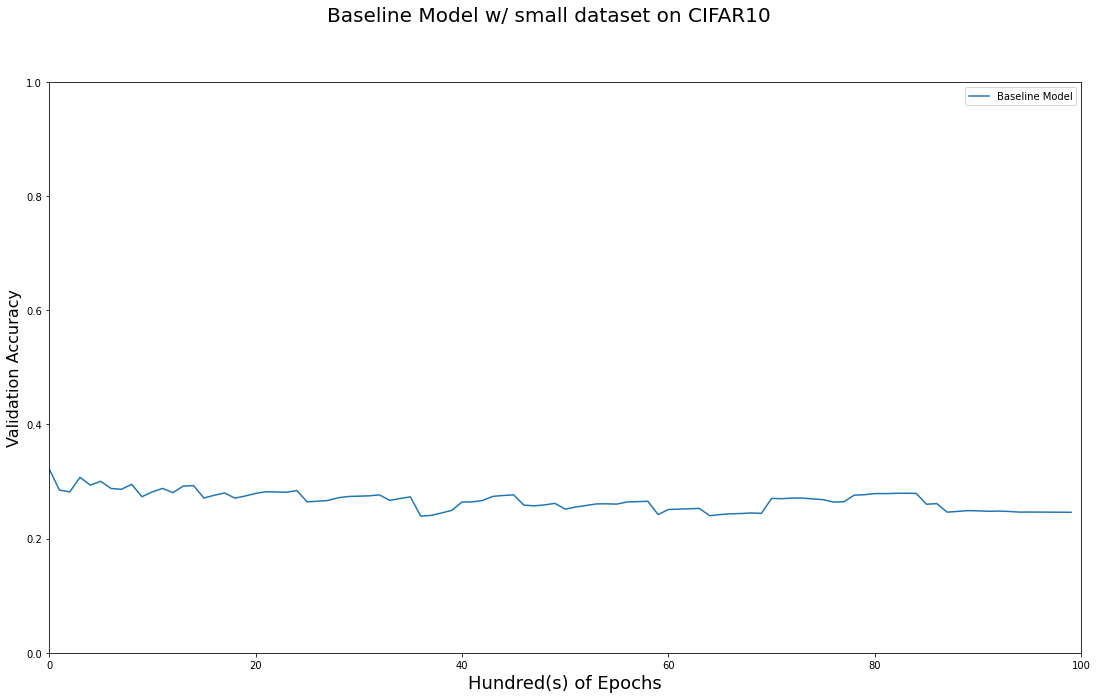

In [ ]:
# plot Baseline

x = np.arange(100)

plt.plot(x, validation_acc_list[1:], label = 'Baseline Model')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('Baseline Model w/ small dataset on CIFAR10', fontsize=20)
plt.xlabel('Hundred(s) of Epochs', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=16)

ax = plt.gca()
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.0])

plt.legend()
plt.show()

4. **The transfer learning task:** \\
(a) Let’s train our third classifier on the 500 CIFAR10 dataset you set aside in the begining. 
Again, note that they are for the original 10-class classification problem. \\
(b) This time, instead of using an initializer, you will reload the weights from the pretext
network you learned in P2.2. Yes, that’s exactly the definition of transfer learning. But,
because you learned it from an unlabeled set, and had to create a pretext task to do so,
it falls in the category of self-supervised learning. \\
(c) Note that you can trasfer all the parameters in except for the final softmax layer, as
the pretext task is only with 3 classes. Let’s randomly initialize this last softmax layer
parameters with He.

In [ ]:
# Set Hyperparameters
n_epochs = 10000 # max_epochs
batch_size_train = 10
batch_size_test = 100
learning_rate = 0.001 # learn rate
log_interval = 100 # log every _ epoch

patience = 20  # epochs after which training should stop if no improvement

In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN2D_transfer_network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv2d = nn.Conv2d(in_channels = 3,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',    
                                stride = (1,1) # stride of conv
          
        ) 
        self.conv2d_2 = nn.Conv2d(in_channels = 10,
                                out_channels = 10, # number filters
                                kernel_size = (5,5), # size of kernel
                                padding = 'same',
                                stride = (1,1) # stride of 
                       
        ) 
        self.maxpool2d = nn.MaxPool2d(kernel_size = (2,2),stride=2)
        
        self.fc7 = nn.Linear(640, 20)
        self.fc3 = nn.Linear(20, 10)
        

        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        #self.LeakyReLU = nn.LeakyReLU()
        #self.Dropout_1 = nn.Dropout(p=.2)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations


        x = self.conv2d(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
 
        x = self.conv2d_2(x)
        x = self.ReLU(x)

        x = self.maxpool2d(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc7(x)
        x = self.ReLU(x)

        x = self.fc3(x)
        x = self.ReLU(x)

        return x

In [ ]:
# import math
# def weight_init(m):
#   if isinstance(m, nn.Linear):
#     torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
#     torch.nn.init.zeros_(m.bias) # fill bias with zeros
#   elif isinstance(m, nn.Conv2d):
#     torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu') # using uniform dists
#     torch.nn.init.zeros_(m.bias) # fill bias with zeros

# Send model to GPU
CNN2D_transfer_network = CNN2D_transfer_network().to(device)
# CNN2D_base_network.apply(weight_init)
CNN2D_transfer_network = CNN2D_transfer_network.float()
print(CNN2D_transfer_network)

CNN2D_transfer_network(
  (conv2d): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2d_2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc7): Linear(in_features=640, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (ReLU): ReLU()
)


In [ ]:
pretrained_dict = torch.load("/content/drive/My Drive/DLS_Assignments/3/Q2_pt_model_state_dict.pt", map_location=torch.device('cpu'))

In [ ]:
CNN2D_transfer_network_dict=CNN2D_transfer_network.state_dict()

In [ ]:
for k in CNN2D_transfer_network_dict:
  print(k)

conv2d.weight
conv2d.bias
conv2d_2.weight
conv2d_2.bias
fc7.weight
fc7.bias
fc3.weight
fc3.bias


In [ ]:
for k in pretrained_dict:
  print(k)

conv2d.weight
conv2d.bias
conv2d_2.weight
conv2d_2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [ ]:
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in CNN2D_transfer_network_dict}

for k in pretrained_dict:
  print(k)



conv2d.weight
conv2d.bias
conv2d_2.weight
conv2d_2.bias


In [ ]:
CNN2D_transfer_network_dict.update(pretrained_dict)
CNN2D_transfer_network.load_state_dict(CNN2D_transfer_network_dict)

<All keys matched successfully>

In [ ]:
torch.nn.init.kaiming_uniform_(CNN2D_transfer_network.fc3.weight, nonlinearity = 'relu') # using uniform dists
torch.nn.init.zeros_(CNN2D_transfer_network.fc3.bias) # fill bias with zeros

torch.nn.init.kaiming_uniform_(CNN2D_transfer_network.fc7.weight, nonlinearity = 'relu') # using uniform dists
torch.nn.init.zeros_(CNN2D_transfer_network.fc7.bias) # fill bias with zeros

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)

In [ ]:
my_list = ['fc3.weight', 'fc3.bias', 'fc7.weight', 'fc7.bias']
params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in my_list, CNN2D_transfer_network.named_parameters()))))
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in my_list, CNN2D_transfer_network.named_parameters()))))


In [ ]:
optimizer = torch.optim.Adam([{'params': base_params},{'params': params, 'lr': 1e-3}], lr = 1e-6)

In [ ]:
# Define optimizer and loss
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_accuracy = 0 # captures best accuracy
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None
validation_acc_list_2 = []

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2)

In [ ]:
from sklearn.metrics import accuracy_score

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2 = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch
 
  print("Training model")

  while ( (epoch <= n_epochs) ):
    
    # Training
    CNN2D_transfer_network.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data = data.to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = CNN2D_transfer_network(data.float())
      loss = loss_func(batch_outputs, batch_labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch


    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :

      # Evaluation 
      CNN2D_transfer_network.eval()
      lbl_list = []
      pred_list = []
      with torch.no_grad():
        for data, target in test_loader:
          
          data = data.to(device)
          test_batch_labels = target.numpy()
          test_batch_pred = F.softmax(CNN2D_transfer_network.forward(data.float()), dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()


          lbl_list.append(test_batch_labels)
          pred_list.append(test_batch_pred)
          

      lbl_array = np.concatenate(lbl_list, axis=0)
      pred_array = np.concatenate(pred_list, axis=0)

      epoch_acc = accuracy_score(lbl_array,pred_array)

      validation_acc_list_2.append(epoch_acc)

      print("Epoch: {}, Total Training Loss: {}, Test Accuracy: {} \n ".format(epoch, train_loss, epoch_acc))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2)
  return Training_Return

In [ ]:
# Train 
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict, validation_acc_list_2 = res


Training model
Epoch: 1, Total Training Loss: 126.34227633476257, Test Accuracy: 0.1524 
 
Epoch: 100, Total Training Loss: 25.816560994950123, Test Accuracy: 0.354 
 
Epoch: 200, Total Training Loss: 25.564302183542168, Test Accuracy: 0.3594 
 
Epoch: 300, Total Training Loss: 24.639523225599987, Test Accuracy: 0.3582 
 
Epoch: 400, Total Training Loss: 23.71823496363595, Test Accuracy: 0.3519 
 
Epoch: 500, Total Training Loss: 22.566711095515757, Test Accuracy: 0.3518 
 
Epoch: 600, Total Training Loss: 22.3386892294875, Test Accuracy: 0.3542 
 
Epoch: 700, Total Training Loss: 22.105119111246495, Test Accuracy: 0.3595 
 
Epoch: 800, Total Training Loss: 21.874934832726915, Test Accuracy: 0.3627 
 
Epoch: 900, Total Training Loss: 21.644545643216816, Test Accuracy: 0.355 
 
Epoch: 1000, Total Training Loss: 21.41482368390166, Test Accuracy: 0.3434 
 
Epoch: 1100, Total Training Loss: 21.41414029291684, Test Accuracy: 0.3512 
 
Epoch: 1200, Total Training Loss: 21.18441531168787, Tes

In [ ]:
import pickle

with open("/content/drive/My Drive/DLS_Assignments/3/Q2_P2_res", "wb") as fp:   
  pickle.dump(validation_acc_list_2, fp)

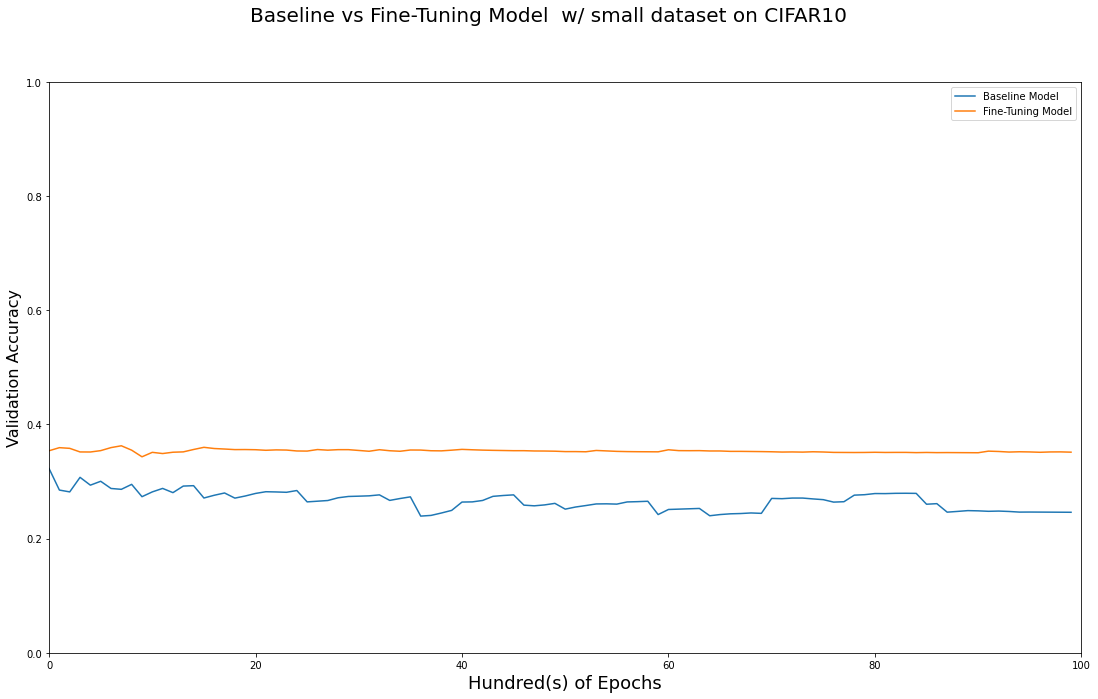

In [ ]:
# plot Graphs

x = np.arange(100)

plt.plot(x, validation_acc_list[1:], label = 'Baseline Model')
plt.plot(x, validation_acc_list_2[1:], label = 'Fine-Tuning Model')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('Baseline vs Fine-Tuning Model  w/ small dataset on CIFAR10', fontsize=20)
plt.xlabel('Hundred(s) of Epochs', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=16)

ax = plt.gca()
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.0])

plt.legend()
plt.show()

Here we are comparing the baseline and fine-tuning model for this very small CIFAR-10 dataset. As you can see the accuracy for the baseline isn't very good, as the training set is too small comapred to our test set. The fine-tuning method of trasnfering the weights from the dummy rotation classifer seems to have improved the performance. The weights for the Convolution layers were tranferred, and the fully connected layers were allowed to retrain with the higher layer rate. This improved perfromance by about 10%, as the convolution layers seem to have learned some useful features.  

### Problem 3: Speech Denoising Using RNN

Load all of them and convert them into spectrograms like you did in Homework 2. Don’t
forget to take their magnitudes.

In [ ]:
# Temporary
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import IPython

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
!pip install librosa # in colab, you’ll need to install this
import librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/tr/"
files_trx = []
files_trs = []
files_trn = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and 'trx' in i:
        files_trx.append(i)
    if os.path.isfile(os.path.join(path,i)) and 'trs' in i:
        files_trs.append(i)
    if os.path.isfile(os.path.join(path,i)) and 'trn' in i:
        files_trn.append(i)


In [ ]:
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/v/"
files_vx = []
files_vs = []
files_vn = []

for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and 'vx' in i:
        files_vx.append(i)
    if os.path.isfile(os.path.join(path,i)) and 'vs' in i:
        files_vs.append(i)
    if os.path.isfile(os.path.join(path,i)) and 'vn' in i:
        files_vn.append(i)

In [ ]:
# path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/te/"
# files_tex = []

# for i in os.listdir(path):
#     if os.path.isfile(os.path.join(path,i)):
#         files_tex.append(i)


In [ ]:
files_trx.sort()
files_trs.sort()
files_trn.sort()
files_vx.sort()
files_vs.sort()
files_vn.sort()
# files_tex.sort()

In [ ]:
# load data for training files and do stft
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/tr/"
# train_trx_time = []
# train_trx_freq = []
train_trx_freq_abs = []
# train_trx_len = []


for file_name in files_trx:

  # Get time-domain signal
  s, sr=librosa.load(os.path.join(path,file_name), sr=None)
  # train_trx_time.append(s)

  # Get freq domain signal
  S=librosa.stft(s, n_fft=1024, hop_length=512)

  # train_trx_len.append(S.shape[1])

  silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

  S = np.concatenate((S.T,silent_new_arr), axis=0, dtype = 'complex_')

  # train_trx_freq.append(S)

  S_abs = np.abs(S)

  train_trx_freq_abs.append(S_abs)


In [ ]:
# load data for training clean files and do stft
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/tr/"
# train_trs_time = []
# train_trs_freq = []
train_trs_freq_abs = []
# train_trs_len = []


for file_name in files_trs:

  # Get time-domain signal
  s, sr=librosa.load(os.path.join(path,file_name), sr=None)
  # train_trs_time.append(s)

  # Get freq domain signal
  S=librosa.stft(s, n_fft=1024, hop_length=512)

  # train_trs_len.append(S.shape[1])

  silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

  S = np.concatenate((S.T,silent_new_arr), axis=0, dtype = 'complex_')

  # train_trs_freq.append(S)

  S_abs = np.abs(S)

  train_trs_freq_abs.append(S_abs)

In [ ]:
# load data for training noise files and do stft
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/tr/"
# train_trn_time = []
# train_trn_freq = []
train_trn_freq_abs = []
# train_trn_len = []


for file_name in files_trn:

  # Get time-domain signal
  s, sr=librosa.load(os.path.join(path,file_name), sr=None)
  # train_trn_time.append(s)

  # Get freq domain signal
  S=librosa.stft(s, n_fft=1024, hop_length=512)

  # train_trn_len.append(S.shape[1])

  silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

  S = np.concatenate((S.T,silent_new_arr), axis=0, dtype = 'complex_')

  # train_trn_freq.append(S)

  S_abs = np.abs(S)

  train_trn_freq_abs.append(S_abs)

In [ ]:
# load data for training files and do stft
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/v/"
# valid_vx_time = []
valid_vx_freq = []
valid_vx_freq_abs = []
valid_vx_len = []


for count,file_name in enumerate(files_vx):

  # Get time-domain signal
  s, sr=librosa.load(os.path.join(path,file_name), sr=None)
  # valid_vx_time.append(s)

  # Get freq domain signal
  S=librosa.stft(s, n_fft=1024, hop_length=512)

  valid_vx_len.append(S.shape[1])

  silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

  S = np.concatenate((S.T,silent_new_arr), axis=0)

  valid_vx_freq.append(S)

  S_abs = np.abs(S)

  valid_vx_freq_abs.append(S_abs)

In [ ]:
# load data for training files and do stft
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/v/"
valid_vs_time = []
# valid_vs_freq = []
valid_vs_freq_abs = []
# valid_vs_len = []


for count, file_name in enumerate(files_vs):

  # Get time-domain signal
  s, sr=librosa.load(os.path.join(path,file_name), sr=None)
  valid_vs_time.append(s)

  # Get freq domain signal
  S=librosa.stft(s, n_fft=1024, hop_length=512)

  # valid_vs_len.append(S.shape[1])

  silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

  S = np.concatenate((S.T,silent_new_arr), axis=0)

  # valid_vs_freq.append(S)

  S_abs = np.abs(S)

  valid_vs_freq_abs.append(S_abs)

In [ ]:
# load data for training files and do stft
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/v/"
# valid_vn_time = []
# valid_vn_freq = []
valid_vn_freq_abs = []
# valid_vn_len = []


for count,file_name in enumerate(files_vn):

  # Get time-domain signal
  s, sr=librosa.load(os.path.join(path,file_name), sr=None)
  # valid_vn_time.append(s)

  # Get freq domain signal
  S=librosa.stft(s, n_fft=1024, hop_length=512)

  # valid_vn_len.append(S.shape[1])

  silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

  S = np.concatenate((S.T,silent_new_arr), axis=0)

  # valid_vn_freq.append(S)

  S_abs = np.abs(S)

  valid_vn_freq_abs.append(S_abs)

In [ ]:
# load data for training files and do stft
# path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/te/"
# test_te_time = []
# test_te_freq = []
# test_te_freq_abs = []
# test_te_len = []


# for file_name in files_tex:

#   # Get time-domain signal
#   s, sr=librosa.load(os.path.join(path,file_name), sr=None)
#   test_te_time.append(s)

#   # Get freq domain signal
#   S=librosa.stft(s, n_fft=1024, hop_length=512)

#   test_te_len.append(S.shape[1])

#   silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

#   S = np.concatenate((S.T,silent_new_arr), axis=0)

#   test_te_freq.append(S)

#   S_abs = np.abs(S)

#   test_te_freq_abs.append(S_abs)

In [ ]:
train_masks = [(train_trs_freq_abs[i] > train_trn_freq_abs[i]).astype(float) for i in range(len(train_trs_freq_abs))]
valid_masks = [(valid_vs_freq_abs[i] > valid_vn_freq_abs[i]).astype(float) for i in range(len(valid_vs_freq_abs))]

In [ ]:
import gc 

del train_trs_freq_abs 
del train_trn_freq_abs 
del valid_vs_freq_abs 
del valid_vn_freq_abs 

gc.collect()

110

In [ ]:
import torch

In [ ]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Set Hyperparameters
n_epochs = 200 # max_epochs
batch_size_val = 10
batch_size_train = 10
learning_rate = 0.001 # learn rate
log_interval = 1 # log every _ epoch
patience = 25  # epochs after which training should stop if no improvement

In [ ]:
train_trx_freq_abs = np.array(train_trx_freq_abs)
valid_vx_freq_abs = np.array(valid_vx_freq_abs)
print(train_trx_freq_abs.shape)
print(valid_vx_freq_abs.shape)

(1200, 200, 513)
(1200, 200, 513)


In [ ]:
train_masks = np.array(train_masks)
valid_masks = np.array(valid_masks)
print(train_masks.shape)
print(valid_masks.shape)

(1200, 200, 513)
(1200, 200, 513)


In [ ]:
train_trx_freq_abs = torch.from_numpy(train_trx_freq_abs)
train_masks = torch.from_numpy(train_masks)

valid_vx_freq_abs = torch.from_numpy(valid_vx_freq_abs)
valid_masks = torch.from_numpy(valid_masks)

In [ ]:
# Get Datasets
from torch.utils.data import TensorDataset, DataLoader

Train_dataset = TensorDataset(train_trx_freq_abs, train_masks)
Valid_dataset = TensorDataset(valid_vx_freq_abs, valid_masks)

train_loader = torch.utils.data.DataLoader(Train_dataset,batch_size=batch_size_train, shuffle=False)
valid_loader = torch.utils.data.DataLoader(Valid_dataset,batch_size=batch_size_val, shuffle=False)

In [ ]:
gc.collect()

188

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RNN_network(nn.Module):
    def __init__(self):
        super().__init__()
        
 
       
        self.lstm = nn.LSTM(input_size = 513,
                            hidden_size = 15,
                            num_layers = 1,
                            batch_first = True
        ) 
  
        self.fc1 = nn.Linear(15*200, 513*200)
        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        #self.LeakyReLU = nn.LeakyReLU()
        # self.Dropout_1 = nn.Dropout(p=.1)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations
        h0 = torch.zeros(1, 10, 15).requires_grad_().to(device)
        c0 = torch.zeros(1, 10, 15).requires_grad_().to(device)
        x, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        x = x.reshape(10, -1)
        x = self.fc1(x)
        x = self.ReLU(x)
    
    
        x = self.Sigmoid(x) 
        x = self.ReLU(x)
        x = x.reshape(10,200,513)

        return x


In [ ]:
# import math
# def weight_init(m):
#   if isinstance(m, nn.Linear):
#       # get the number of the inputs
#       n = m.in_features
#       y = 1.0/np.sqrt(n)
#       m.weight.data.uniform_(-y, y)
#       m.bias.data.fill_(0.0)
#   elif isinstance(m, nn.Conv2d):
#       torch.nn.init.xavier_uniform_(m.weight)
#       m.bias.data.fill_(0.0)

# Send model to GPU
RNN_network = RNN_network().to(device)
# CNN2D_network.apply(weight_init)
RNN_network = RNN_network.float()
print(RNN_network)

RNN_network(
  (lstm): LSTM(513, 15, batch_first=True)
  (fc1): Linear(in_features=3000, out_features=102600, bias=True)
  (ReLU): ReLU()
  (Sigmoid): Sigmoid()
)


In [ ]:
for name, param in RNN_network.named_parameters():
  if 'bias' in name:
    nn.init.zeros_(param)
  elif (('weight' in name) and ('lstm' in name)):
    nn.init.xavier_normal_(param)
  elif ('weight' in name):
    nn.init.kaiming_uniform_(param, nonlinearity = 'relu') # using uniform dists

In [ ]:
# Define optimizer and loss
optimizer = torch.optim.Adam(RNN_network.parameters(), lr = learning_rate)
loss_func = torch.nn.MSELoss()

In [ ]:
# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_metric = -1 * float('inf') # captures best metric
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict)

In [ ]:
from sklearn.metrics import mean_squared_error
import copy

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch

  stop_training = False # set to stop model training

  patience_rounds = 0 # number of patience rounds
 
  print("Training model")

  while ( (stop_training == False) and (epoch <= n_epochs) ):
    
    # Training
    RNN_network.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      input_data = data.to(device)
      batch_target = target.to(device)

      # Forward pass
      batch_outputs = RNN_network(input_data.float())
      # x = (x>0.5).float()
      # loss = loss_func((batch_outputs.float() > 0.5).float(), batch_target.float())
      loss = loss_func(batch_outputs.float(), batch_target.float())

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch

    
   # Evaluation 
    RNN_network.eval()
    lbl_list = []
    pred_list = []
    with torch.no_grad():
      for data, target in valid_loader:
        
        val_input = data.to(device)
        
        test_batch_pred = RNN_network.forward(val_input.float())
        
        val_batch_target = target.numpy()
        
        test_batch_pred = test_batch_pred.cpu().numpy()

        lbl_list.append(val_batch_target)
        test_batch_pred = (test_batch_pred.astype(float) > 0.5).astype(float)
        pred_list.append(test_batch_pred)
      
        

    lbl_array = np.concatenate(lbl_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)

    average_SNR = 0

    # Calculate validation set SNR on first 300 as eval func
    for sample in range(300):
      # raw_result = ( (valid_vx_freq[sample][0:valid_vx_len[sample], :]).T / np.abs( (valid_vx_freq[sample][0:valid_vx_len[sample], :]).T ) ) * np.abs( (pred_array[sample].T * valid_vx_freq[sample].T)[:,0:valid_vx_len[sample]])
      raw_result = (pred_array[sample].T * valid_vx_freq[sample].T)[:,0:valid_vx_len[sample]]
      result = librosa.istft(stft_matrix = raw_result,  hop_length=512)

      result_clean = valid_vs_time[sample][0:result.size]

      clean_t = result_clean
      denoised_t = result

      r1 = np.dot(clean_t,clean_t)
      r2 = np.dot((clean_t - denoised_t), (clean_t - denoised_t))
      valid_SNR = 10*np.log10(r1/(r2+1e-20))
      average_SNR += valid_SNR

    epoch_metric = average_SNR / 300
    epoch_metric_mse = np.square(np.subtract(pred_array, lbl_array)).mean()
    
    # Early Stop
    # if acc better than previous
    if(epoch_metric > bst_metric):
      # reset patience
      patience_rounds = 0

      # Save result
      bst_metric = epoch_metric

      # Save Model
      bst_model = copy.deepcopy(RNN_network) 
      bst_model_state_dict = RNN_network.state_dict()
      bst_opt_state_dict = optimizer.state_dict()
      # torch.save(model, 'best_mnist_model.pt')

    # if epoch acc worse
    else:
      # inc patience
      patience_rounds += 1
      if(patience_rounds >= patience):
        stop_training = True
        print("Stopping!")
    
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Total Training Loss: {}, Total Validation Loss: {}, Epoch Validation SNR: {}, Best Validation SNR: {} \n ".format(epoch, train_loss,epoch_metric_mse, epoch_metric, bst_metric))
    # increment epoch
    epoch += 1

  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict)
  return Training_Return

In [ ]:
# Train 
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict = res

# Best Model
print("Best Metric Model was : {:.2f}".format(bst_metric))

Training model
Epoch: 1, Total Training Loss: 29.60572277009487, Total Validation Loss: 0.4260396280051982, Epoch Validation SNR: 2.535234532878293, Best Validation SNR: 2.535234532878293 
 
Epoch: 2, Total Training Loss: 28.979280158877373, Total Validation Loss: 0.42321110298895387, Epoch Validation SNR: 3.1162563369296494, Best Validation SNR: 3.1162563369296494 
 
Epoch: 3, Total Training Loss: 28.592055082321167, Total Validation Loss: 0.4125285168940871, Epoch Validation SNR: 3.2896307145566315, Best Validation SNR: 3.2896307145566315 
 
Epoch: 4, Total Training Loss: 28.066786721348763, Total Validation Loss: 0.40835647335932423, Epoch Validation SNR: 4.1825473724023965, Best Validation SNR: 4.1825473724023965 
 
Epoch: 5, Total Training Loss: 27.469841226935387, Total Validation Loss: 0.4026913255360624, Epoch Validation SNR: 4.686492305388942, Best Validation SNR: 4.686492305388942 
 
Epoch: 6, Total Training Loss: 26.919839307665825, Total Validation Loss: 0.40498490903183887

In [ ]:
bst_model.eval()
import statistics
lbl_list = []
pred_list = []
with torch.no_grad():
  for data in valid_loader:
    
    val_input = data[0].to(device)
    
    test_batch_pred = bst_model.forward(val_input.float())
    

    
    test_batch_pred = test_batch_pred.cpu().numpy()


    test_batch_pred = (test_batch_pred.astype(float) > 0.5).astype(float)
    pred_list.append(test_batch_pred)
  
    


pred_array = np.concatenate(pred_list, axis=0)

average_SNR = 0
SNR_list = []
# Calculate validation set SNR on first 300 as eval func
for sample in range(1200):
  # raw_result = ( (valid_vx_freq[sample][0:valid_vx_len[sample], :]).T / np.abs( (valid_vx_freq[sample][0:valid_vx_len[sample], :]).T ) ) * np.abs( (pred_array[sample].T * valid_vx_freq[sample].T)[:,0:valid_vx_len[sample]])
  raw_result = (pred_array[sample].T * valid_vx_freq[sample].T)[:,0:valid_vx_len[sample]]
  result = librosa.istft(stft_matrix = raw_result,  hop_length=512)

  result_clean = valid_vs_time[sample][0:result.size]

  clean_t = result_clean
  denoised_t = result

  r1 = np.dot(clean_t,clean_t)
  r2 = np.dot((clean_t - denoised_t), (clean_t - denoised_t))
  valid_SNR = 10*np.log10(r1/(r2+1e-20))
  average_SNR += valid_SNR
  SNR_list.append(valid_SNR)

epoch_metric = average_SNR / 1200

In [ ]:
print("validation SNR mean : ", epoch_metric)

validation SNR mean :  8.273647930025302


In [ ]:
# Getting test data
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/te/"
files_tex = []

for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)):
        files_tex.append(i)

In [ ]:
files_tex.sort()

In [ ]:
# load data for training files and do stft
path = "/content/drive/My Drive/DLS_Assignments/3/homework3/timit-homework/te/"
test_te_time = []
test_te_freq = []
test_te_freq_abs = []
test_te_len = []


for file_name in files_tex:

  # Get time-domain signal
  s, sr=librosa.load(os.path.join(path,file_name), sr=None)
  test_te_time.append(s)

  # Get freq domain signal
  S=librosa.stft(s, n_fft=1024, hop_length=512)

  test_te_len.append(S.shape[1])

  silent_new_arr = (np.random.rand(200-S.shape[1],513) * 1e-20) + (np.random.rand(200-S.shape[1],513) * 1e-20) * 1j

  S = np.concatenate((S.T,silent_new_arr), axis=0)

  test_te_freq.append(S)

  S_abs = np.abs(S)

  test_te_freq_abs.append(S_abs)

In [ ]:
test_te_freq_abs = torch.from_numpy(np.array(test_te_freq_abs))
Test_dataset = TensorDataset(test_te_freq_abs)
test_loader = torch.utils.data.DataLoader(Test_dataset,batch_size=10, shuffle=False)

In [ ]:
test_te_freq[0].shape

(200, 513)

In [ ]:
pred_array[0].shape

(200, 513)

In [ ]:
bst_model.eval()
import soundfile as sf
import os.path
pred_list = []
with torch.no_grad():
  for data in test_loader:
    

    test_batch_pred = bst_model.forward(data[0].to(device).float())
    
    test_batch_pred = test_batch_pred.cpu().numpy()

    test_batch_pred = (test_batch_pred.astype(float) > 0.5).astype(float)
    pred_list.append(test_batch_pred)
  
pred_array = np.concatenate(pred_list, axis=0)

for sample in range(len(test_te_len)):
  # raw_result = ( (test_te_freq[sample][0:test_te_len[sample], :]).T / np.abs( (test_te_freq[sample][0:test_te_len[sample], :]).T ) ) * np.abs( (pred_array[sample].T * test_te_freq[sample].T)[:,0:test_te_len[sample]])
  raw_result = (pred_array[sample].T * test_te_freq[sample].T)[:,0:test_te_len[sample]]
  result = librosa.istft(stft_matrix = raw_result,  hop_length=512)
  save_path = os.path.join("/content/drive/My Drive/DLS_Assignments/3/Q3_output/",  'ter'+str(sample)+'.wav')
  sf.write(save_path, result, sr)
  

In [ ]:
IPython.display.Audio("/content/drive/My Drive/DLS_Assignments/3/Q3_output/ter310.wav")

In [ ]:
IPython.display.Audio("/content/drive/My Drive/DLS_Assignments/3/Q3_output/ter15.wav")